<a href="https://colab.research.google.com/github/stephaniediamond3/DATA71200/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Find and download a dataset.

In [ ]:
# website https://www.cdc.gov/nchs/data_access/VitalStatsOnline.htm
# dta file https://data.nber.org/nvss/natality/dta/

#call data
!wget -O natality2024us.dta https://data.nber.org/nvss/natality/dta/2024/natality2024us.dta



--2025-10-31 22:36:23--  https://data.nber.org/nvss/natality/dta/2024/natality2024us.dta
Resolving data.nber.org (data.nber.org)... 198.71.6.39, 198.71.6.22
Connecting to data.nber.org (data.nber.org)|198.71.6.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 913399671 (871M)
Saving to: ‘natality2024us.dta’

natality2024us.dta  100%[===================>] 871.08M  1.08MB/s    in 13m 52s 

2025-10-31 22:50:16 (1.05 MB/s) - ‘natality2024us.dta’ saved [913399671/913399671]



In [ ]:
import pandas as pd

#Select relevant columns
cols = [
    # Maternal morbidity indicators
    "mm_mtr","mm_plac","mm_rupt","mm_uhyst","mm_aicu",
    # Risk factors
    "rf_pdiab","rf_gdiab","rf_phype","rf_ghype","rf_ehype",
    "rf_ppterm","rf_inftr","rf_fedrg","rf_artec","rf_cesar",
    "rf_cesarn","no_risks",
    # SES proxies
    "meduc","wic","pay_rec",
    # Race/ethnicity
    "mracehisp","mhisp_r","mrace6",
    # Health behaviors
    "bmi_r","cig0_r","precare5",
    # Demographics/pregnancy context
    "mager","dplural","lbo_rec","tbo_rec",
    "priorlive","priordead","priorterm",
    # Gestational age
    "gestrec10"
]

# create df
df = pd.read_stata("natality2024us.dta", columns=cols, convert_categoricals=False)


In [ ]:
### TRIMMED COPY ###
#from google.colab import drive
#drive.mount('/content/drive')
#df.to_parquet("/content/drive/MyDrive/natality2024_trimmed.parquet", index=False)

### READ BACK IN ###

#from google.colab import drive
#drive.mount('/content/drive')

#import pandas as pd
#df = pd.read_parquet("/content/drive/MyDrive/natality2024_trimmed.parquet")


Mounted at /content/drive


Create New Vars

In [ ]:
import numpy as np

# Define maternal morbidity indicator columns
mm_cols = ["mm_mtr","mm_plac","mm_rupt","mm_uhyst","mm_aicu"]

# SMM composite
df["smm"] = np.where(df[mm_cols].eq(1).any(axis=1), 1, np.nan)
df.loc[df[mm_cols].eq(0).all(axis=1), "smm"] = 0

df["smm"] = df["smm"].astype(float)

# Check
print("SMM\n", df["smm"].value_counts(dropna=False))



SMM
 smm
0.0    3570721
1.0      55637
NaN      12078
Name: count, dtype: int64


Step 2: Divide into a training set and a testing set.

In [ ]:
from sklearn.model_selection import train_test_split

# Prep
df_model = df.dropna(subset=["smm"]).copy()

mm_cols = ["mm_mtr","mm_plac","mm_rupt","mm_uhyst","mm_aicu"]
y = df_model["smm"]
X = df_model.drop(columns=["smm"] + mm_cols)

# Train/test split with stratification to preserve SMM balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=66, test_size=0.3, stratify=y
)

# Check shapes/balance
print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


(2538450, 30) (1087908, 30)
smm
0.0    0.984658
1.0    0.015342
Name: proportion, dtype: float64
smm
0.0    0.984658
1.0    0.015342
Name: proportion, dtype: float64


Step 3: Explore your training set.

In [ ]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2538450 entries, 285186 to 3427017
Data columns (total 30 columns):
 #   Column     Dtype  
---  ------     -----  
 0   rf_pdiab   float64
 1   rf_gdiab   float64
 2   rf_phype   float64
 3   rf_ghype   float64
 4   rf_ehype   float64
 5   rf_ppterm  float64
 6   rf_inftr   float64
 7   rf_fedrg   float64
 8   rf_artec   float64
 9   rf_cesar   float64
 10  rf_cesarn  int8   
 11  no_risks   int8   
 12  meduc      int8   
 13  wic        object 
 14  pay_rec    int8   
 15  mracehisp  int8   
 16  mhisp_r    int8   
 17  mrace6     int8   
 18  bmi_r      int8   
 19  cig0_r     int8   
 20  precare5   int8   
 21  mager      int8   
 22  dplural    int8   
 23  lbo_rec    int8   
 24  tbo_rec    int8   
 25  priorlive  int8   
 26  priordead  int8   
 27  priorterm  int8   
 28  gestrec10  int8   
 29  any_risk   float64
dtypes: float64(11), int8(18), object(1)
memory usage: 295.3+ MB


In [ ]:
X_train.describe(include="all")

rf_pdiab      rf_gdiab      rf_phype      rf_ghype      rf_ehype  \
count   2.535867e+06  2.535867e+06  2.535867e+06  2.535867e+06  2.535867e+06   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    1.312727e-02  8.468780e-02  3.349032e-02  1.041514e-01  2.259977e-03   
std     1.138198e-01  2.784166e-01  1.799131e-01  3.054569e-01  4.748547e-02   
min     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

           rf_ppterm      rf_inftr      rf_fedrg      rf_artec      rf_cesar  \
count   2.535867e+06  2.535867e+06  62454.000000  62454.000000  2.535867e+06   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    3.986290e-02  2.522727e-02      0.318122      0.783441  1.543843e-01   
std     1.956371e-01  1.568147e-01      0.465751      0.411903  3.613168e-01   
min     0.000000e+00  0.000000e+00      0.000000      0.000000  0.000000e+00   
25%     0.000000e+00  0.000000e+00      0.000000      1.000000  0.000000e+00   
50%     0.000000e+00  0.000000e+00      0.000000      1.000000  0.000000e+00   
75%     0.000000e+00  0.000000e+00      1.000000      1.000000  0.000000e+00   
max     1.000000e+00  1.000000e+00      1.000000      1.000000  1.000000e+00   

        ...      precare5         mager       dplural       lbo_rec  \
count   ...  2.538450e+06  2.538450e+06  2.538450e+06  2.538450e+06   
unique  ...           NaN           NaN           NaN           NaN   
top     ...           NaN           NaN           NaN           NaN   
freq    ...           NaN           NaN           NaN           NaN   
mean    ...  1.410013e+00  2.967182e+01  1.031529e+00  2.145414e+00   
std     ...  8.378365e-01  5.814394e+00  1.791826e-01  1.358024e+00   
min     ...  1.000000e+00  1.200000e+01  1.000000e+00  1.000000e+00   
25%     ...  1.000000e+00  2.500000e+01  1.000000e+00  1.000000e+00   
50%     ...  1.000000e+00  3.000000e+01  1.000000e+00  2.000000e+00   
75%     ...  2.000000e+00  3.400000e+01  1.000000e+00  3.000000e+00   
max     ...  5.000000e+00  5.000000e+01  4.000000e+00  9.000000e+00   

             tbo_rec     priorlive     priordead     priorterm     gestrec10  \
count   2.538450e+06  2.538450e+06  2.538450e+06  2.538450e+06  2.538450e+06   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean    2.576739e+00  1.285912e+00  3.072166e-01  8.130631e-01  6.945091e+00   
std     1.702892e+00  4.335282e+00  5.372818e+00  6.043440e+00  2.557562e+00   
min     1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%     1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  6.000000e+00   
50%     2.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  7.000000e+00   
75%     3.000000e+00  2.000000e+00  0.000000e+00  1.000000e+00  8.000000e+00   
max     9.000000e+00  9.900000e+01  9.900000e+01  9.900000e+01  9.900000e+01   

        any_risk  
count   913722.0  
unique       NaN  
top          NaN  
freq         NaN  
mean         1.0  
std          0.0  
min          1.0  
25%          1.0  
50%          1.0  
75%          1.0  
max          1.0  

[11 rows x 30 columns]

In [ ]:
X_train.isna().sum().sort_values(ascending=False).head(15)

rf_artec     2475996
rf_fedrg     2475996
any_risk     1624728
rf_phype        2583
rf_pdiab        2583
rf_ghype        2583
rf_ppterm       2583
rf_ehype        2583
rf_inftr        2583
rf_cesar        2583
rf_gdiab        2583
rf_cesarn          0
meduc              0
no_risks           0
wic                0
dtype: int64

In [ ]:
X_train.select_dtypes("object").nunique()

wic    3
dtype: int64

Step 4: Data cleaning.

In [ ]:
X_train.isna().mean().sort_values(ascending=False).head(15)

rf_artec     0.975397
rf_fedrg     0.975397
any_risk     0.640047
rf_phype     0.001018
rf_pdiab     0.001018
rf_ghype     0.001018
rf_ppterm    0.001018
rf_ehype     0.001018
rf_inftr     0.001018
rf_cesar     0.001018
rf_gdiab     0.001018
rf_cesarn    0.000000
meduc        0.000000
no_risks     0.000000
wic          0.000000
dtype: float64

In [ ]:
# Drop very incomplete variables
drop_cols = ["rf_artec", "rf_fedrg", "any_risk"]
X_train = X_train.drop(columns=drop_cols, errors="ignore")
X_test = X_test.drop(columns=drop_cols, errors="ignore")

from sklearn.impute import SimpleImputer
#Since all vars w ~.01% missing are Y/N binaries, will impute mode
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(X_train)
X_train_new = imp_mode.transform(X_train)
X_test_new = imp_mode.transform(X_test)

X_train = pd.DataFrame(X_train_new, columns=X_train.columns)
X_test = pd.DataFrame(X_test_new, columns=X_test.columns)


Step 5: Visualize the data in your training set.

/tmp/ipython-input-3372746597.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X_train = X_train.apply(pd.to_numeric, errors="ignore")


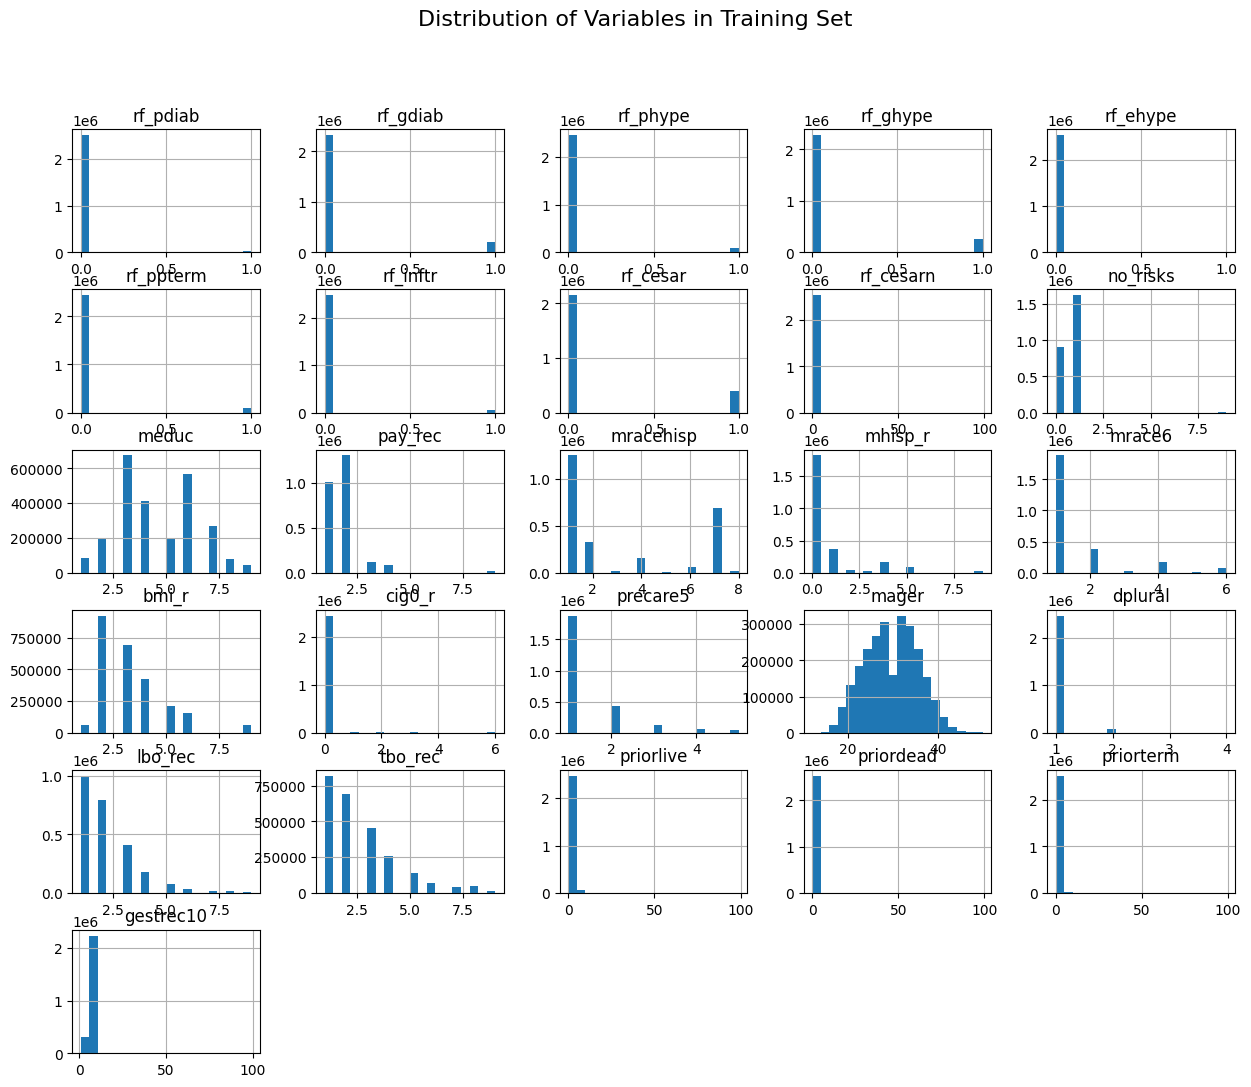

In [ ]:
import matplotlib.pyplot as plt

X_train = X_train.apply(pd.to_numeric, errors="ignore")

X_train.hist(figsize=(15, 12), bins=20)
plt.suptitle("Distribution of Variables in Training Set", fontsize=16)
plt.show()


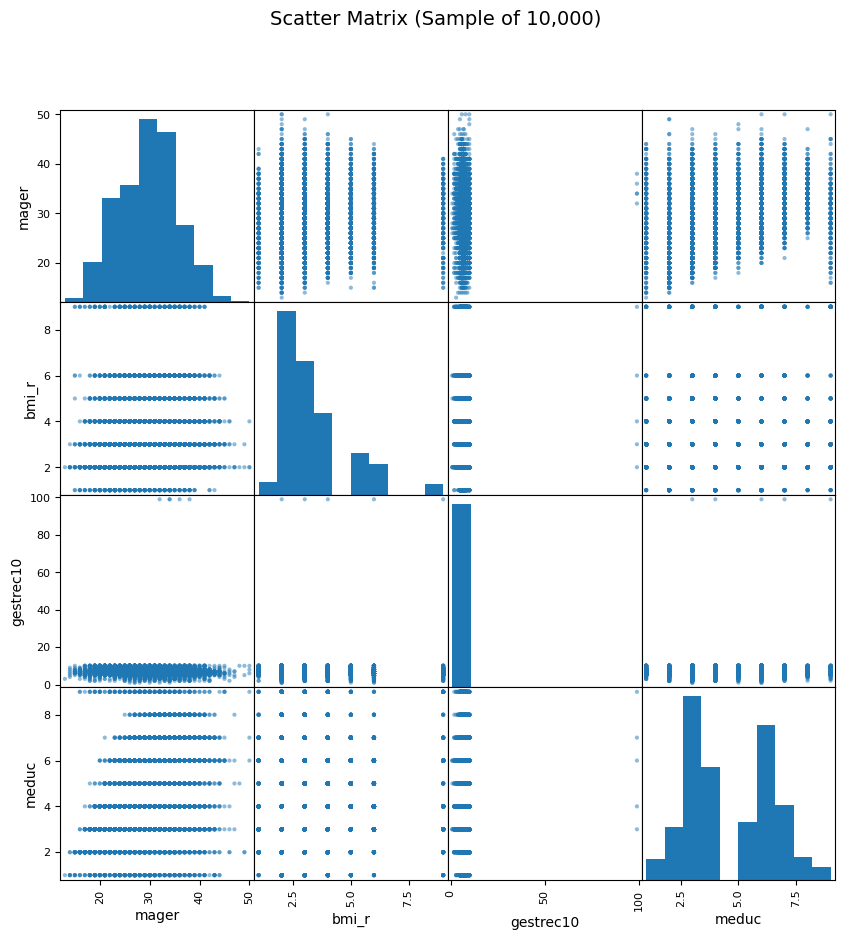

In [ ]:
from pandas.plotting import scatter_matrix

sample = X_train.sample(n=10000, random_state=42)

scatter_matrix(sample[["mager", "bmi_r", "gestrec10", "meduc"]],
               figsize=(10, 10), diagonal='hist', alpha=0.5)
plt.suptitle("Scatter Matrix (Sample of 10,000)", fontsize=14)
plt.show()

# full data set- over 3MM cases, takes a really long time to run
#scatter_matrix(X_train[["mager", "bmi_r", "gestrec10", "meduc"]], figsize=(10, 10))

Step 6: Apply transformations to your data

In [ ]:
# maternal age
X_train["mager_sq"] = np.square(X_train["mager"])
X_train["mager_cube"] = np.power(X_train["mager"], 3)
X_train["mager_log"] = np.log(X_train["mager"] + 1)
X_train["mager_exp"] = np.exp(X_train["mager"] / X_train["mager"].max())

# gestational age
X_train["gest_sq"] = np.square(X_train["gestrec10"])
X_train["gest_cube"] = np.power(X_train["gestrec10"], 3)
X_train["gest_log"] = np.log(X_train["gestrec10"] + 1)
X_train["gest_exp"] = np.exp(X_train["gestrec10"] / X_train["gestrec10"].max())


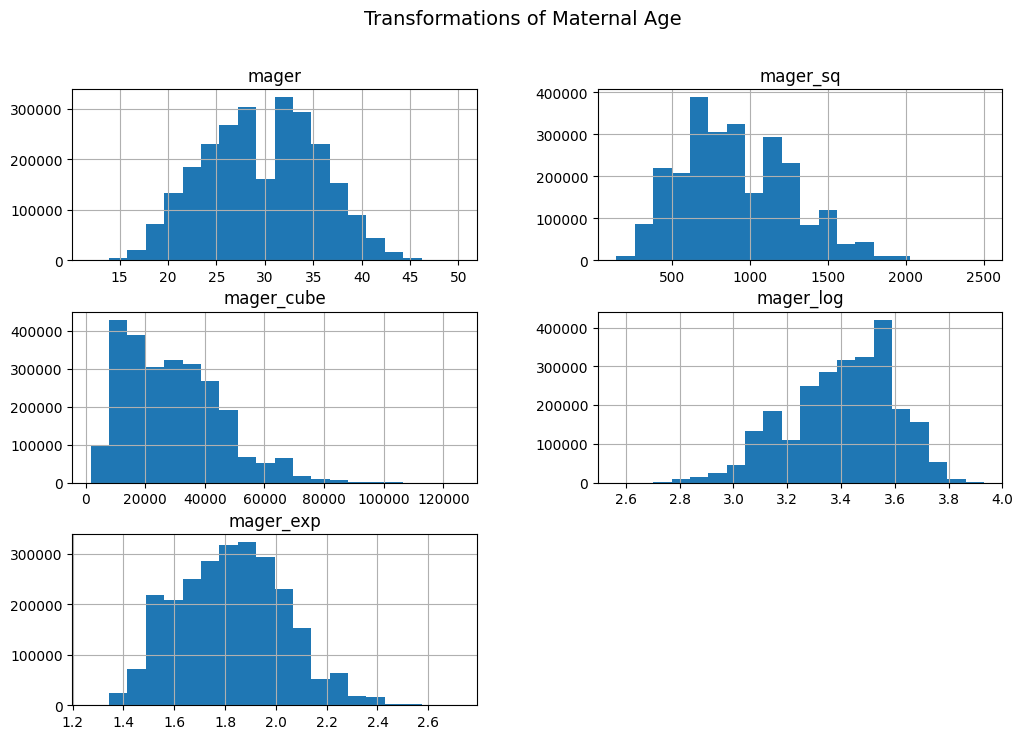

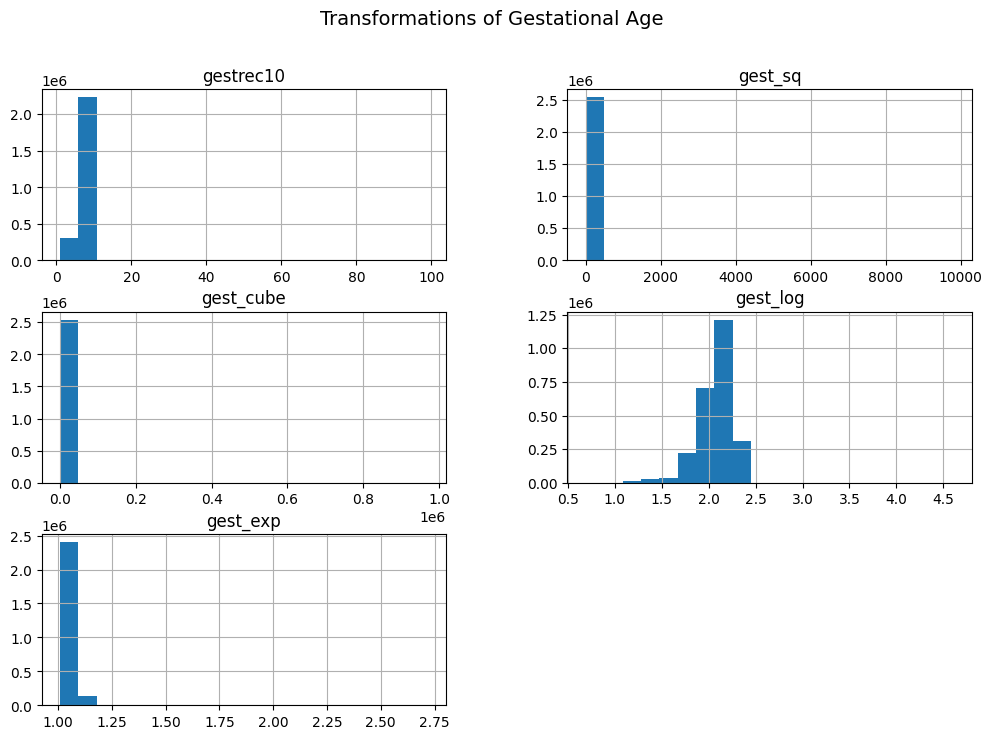

In [ ]:
#histograms

X_train[["mager","mager_sq","mager_cube","mager_log","mager_exp"]].hist(
    figsize=(12,8), bins=20
)
plt.suptitle("Transformations of Maternal Age", fontsize=14)
plt.show()

X_train[["gestrec10","gest_sq","gest_cube","gest_log","gest_exp"]].hist(
    figsize=(12,8), bins=20
)
plt.suptitle("Transformations of Gestational Age", fontsize=14)
plt.show()


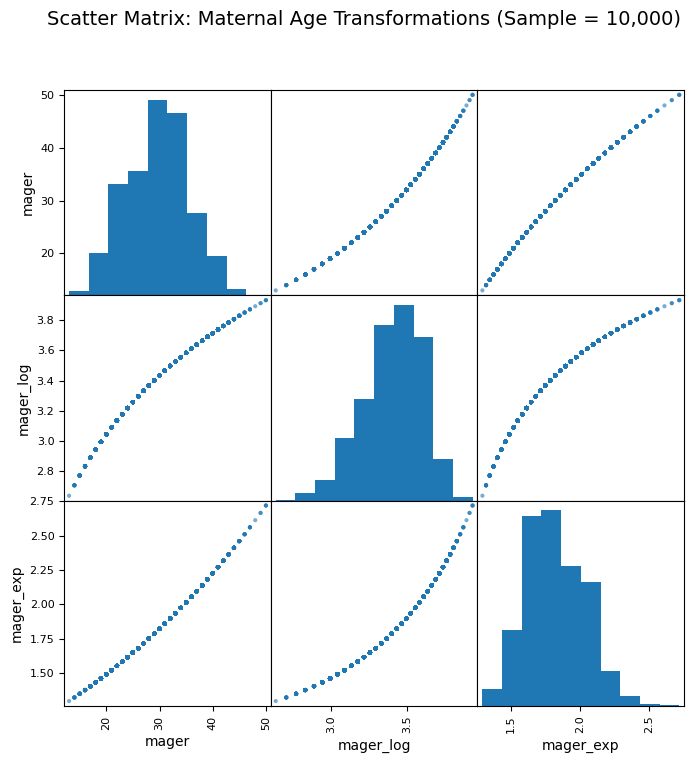

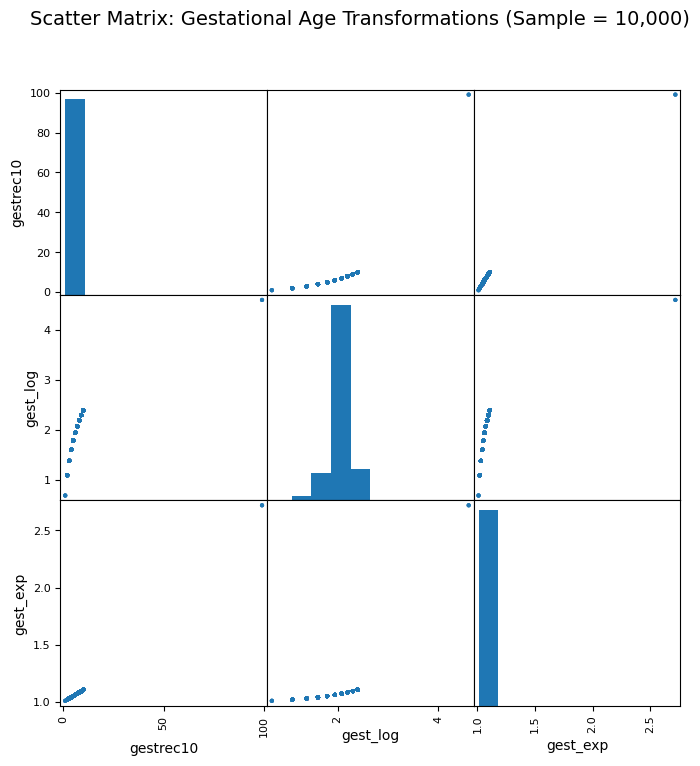

In [ ]:
#scatter matrices

sample_df = X_train.sample(n=10000, random_state=42)
scatter_matrix(sample_df[["mager", "mager_log", "mager_exp"]], figsize=(8, 8), alpha=0.6)
plt.suptitle("Scatter Matrix: Maternal Age Transformations (Sample = 10,000)", fontsize=14)
plt.show()


sample_df = X_train.sample(n=10000, random_state=42)
scatter_matrix(sample_df[["gestrec10", "gest_log", "gest_exp"]], figsize=(8, 8), alpha=0.6)
plt.suptitle("Scatter Matrix: Gestational Age Transformations (Sample = 10,000)", fontsize=14)
plt.show()
